In [1]:
# Anti-Money Laundering Detection using Clustering Algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 1. Load your preprocessed X_data and y_data files
folder_path = Path('/Users/grace/Desktop/524data')

# Load the preprocessed data files
X_data = pd.read_csv(folder_path / 'x_data.csv') if (folder_path / 'x_data.csv').exists() else pd.read_pickle(folder_path / 'x_data')
y_data = pd.read_csv(folder_path / 'y_data.csv') if (folder_path / 'y_data.csv').exists() else pd.read_pickle(folder_path / 'y_data')

# Convert y_data to numpy array if it's a DataFrame
if isinstance(y_data, pd.DataFrame):
    y_data = y_data.values.ravel()

print("Loaded preprocessed data:")
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {len(y_data)}")

# Display distribution of money laundering transactions
value_counts = pd.Series(y_data).value_counts()
print("\nMoney Laundering Distribution:")
print(value_counts)
print(f"Percentage of money laundering: {value_counts.get(1, 0)/len(y_data)*100:.2f}%")

# 2. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# 3. Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Loaded preprocessed data:
X_data shape: (23889295, 55)
y_data shape: 23889295

Money Laundering Distribution:
0    11991259
1    11898036
Name: count, dtype: int64
Percentage of money laundering: 49.80%


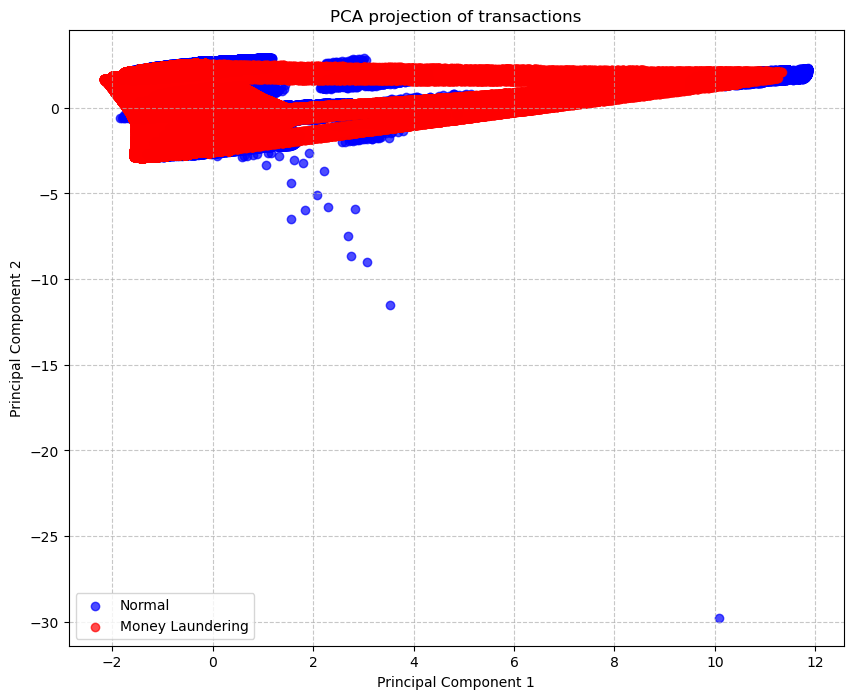

In [2]:
# Plot PCA projection with actual labels
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[y_data == 0, 0], X_pca[y_data == 0, 1], c='blue', label='Normal', alpha=0.7)
plt.scatter(X_pca[y_data == 1, 0], X_pca[y_data == 1, 1], c='red', label='Money Laundering', alpha=0.7)
plt.title('PCA projection of transactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# 4. t-SNE visualization
print("Generating t-SNE visualization...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[y_data == 0, 0], X_tsne[y_data == 0, 1], c='blue', label='Normal', alpha=0.7)
plt.scatter(X_tsne[y_data == 1, 0], X_tsne[y_data == 1, 1], c='red', label='Money Laundering', alpha=0.7)
plt.title('t-SNE projection of transactions')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Generating t-SNE visualization...


python(6201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
# 5. K-means clustering implementation
def apply_kmeans(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    return clusters, kmeans

In [ ]:
# 6. DBSCAN implementation with parameter optimization
def find_optimal_eps(X):
    from sklearn.neighbors import NearestNeighbors
    
    # Calculate distances to nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=15)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Sort distances in ascending order
    distances_sorted = np.sort(distances[:, -1])
    
    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances_sorted)
    plt.title('K-distance Graph for DBSCAN')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to 15th nearest neighbor')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Find the "elbow" point
    try:
        from kneed import KneeLocator
        knee = KneeLocator(range(len(distances_sorted)), distances_sorted, 
                          curve='convex', direction='increasing')
        
        # Plot the elbow point
        optimal_eps = distances_sorted[knee.knee]
        plt.axhline(y=optimal_eps, linestyle='--', color='r', 
                   label=f'Optimal eps: {optimal_eps:.2f}')
        plt.legend()
    except:
        # If knee detection fails, use a heuristic
        optimal_eps = np.median(distances_sorted)
        plt.axhline(y=optimal_eps, linestyle='--', color='r', 
                   label=f'Median distance as eps: {optimal_eps:.2f}')
        plt.legend()
    
    plt.show()
    
    return optimal_eps

def apply_dbscan(X, eps, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    return clusters, dbscan

In [ ]:

# 7. Isolation Forest implementation
def apply_isolation_forest(X, contamination):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    # Isolation Forest returns 1 for inliers and -1 for outliers
    predictions = iso_forest.fit_predict(X)
    clusters = np.where(predictions == -1, 1, 0)  # Convert -1 to 1 (anomaly) and 1 to 0 (normal)
    return clusters, iso_forest

In [ ]:
# 8. Hierarchical Clustering implementation
def apply_hierarchical_clustering(X, n_clusters=2):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hierarchical.fit_predict(X)
    return clusters, hierarchical

In [ ]:
# 9. Visualization function for clustering results
def visualize_clusters(X_2d, clusters, y_true, algorithm_name):
    plt.figure(figsize=(15, 6))
    
    # First subplot: Clusters
    plt.subplot(1, 2, 1)
    unique_clusters = np.unique(clusters)
    
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
    for i, cluster in enumerate(unique_clusters):
        if cluster == -1:  # Noise points in DBSCAN
            plt.scatter(X_2d[clusters == cluster, 0], X_2d[clusters == cluster, 1], 
                        s=30, c='black', label='Noise')
        else:
            plt.scatter(X_2d[clusters == cluster, 0], X_2d[clusters == cluster, 1], 
                        s=30, c=colors[i % len(colors)], label=f'Cluster {cluster}')
    
    plt.title(f'Clustering Results - {algorithm_name}')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Second subplot: Actual labels
    plt.subplot(1, 2, 2)
    plt.scatter(X_2d[y_true == 0, 0], X_2d[y_true == 0, 1], s=30, c='blue', label='Normal')
    plt.scatter(X_2d[y_true == 1, 0], X_2d[y_true == 1, 1], s=30, c='red', label='Money Laundering')
    plt.title('Actual Labels')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 10. Evaluation function
def evaluate_clustering(y_true, y_pred, algorithm_name, X_scaled=None):
    # For DBSCAN, convert -1 (noise) to 1 (anomaly)
    if -1 in y_pred:
        y_pred_binary = np.where(y_pred == -1, 1, 0)
    # For K-means and Hierarchical, map clusters to labels
    elif algorithm_name in ['K-means', 'Hierarchical Clustering'] and len(np.unique(y_pred)) == 2:
        # Check if we need to flip the labels
        # Determine majority class in each cluster
        cluster0_laundering = np.mean(y_true[y_pred == 0]) > 0.5
        if cluster0_laundering:  # If cluster 0 has more money laundering
            y_pred_binary = 1 - y_pred  # Flip labels
        else:
            y_pred_binary = y_pred
    else:
        y_pred_binary = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    
    try:
        auc_roc = roc_auc_score(y_true, y_pred_binary)
    except:
        auc_roc = float('nan')  # In case of single class prediction
    
    # Calculate silhouette score if possible
    silhouette_avg = None
    if X_scaled is not None and algorithm_name not in ['Isolation Forest'] and len(np.unique(y_pred)) > 1:
        try:
            silhouette_avg = silhouette_score(X_scaled, y_pred)
            print(f"Silhouette Score: {silhouette_avg:.4f}")
        except:
            silhouette_avg = None
    
    print(f"\n{algorithm_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    if silhouette_avg is not None:
        print(f"Silhouette Score: {silhouette_avg:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Money Laundering'], 
                yticklabels=['Normal', 'Money Laundering'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {algorithm_name}')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_binary, target_names=['Normal', 'Money Laundering']))
    
    return accuracy, precision, recall, f1, auc_roc, silhouette_avg

In [ ]:
# 11. Summarize cluster characteristics
def summarize_clusters(X_data, clusters, algorithm_name):
    """Summarize the characteristics of each cluster"""
    
    # Create a DataFrame with the original features and cluster assignments
    if isinstance(X_data, pd.DataFrame):
        cluster_df = X_data.copy()
    else:
        cluster_df = pd.DataFrame(X_data, columns=[f'Feature_{i}' for i in range(X_data.shape[1])])
    
    cluster_df['Cluster'] = clusters
    
    # Calculate summary statistics for each cluster
    cluster_summary = cluster_df.groupby('Cluster').agg(['mean', 'median', 'std'])
    
    print(f"\nCluster Characteristics for {algorithm_name}:")
    print(cluster_summary)
    
    return cluster_summary

In [ ]:
# 12. Compare algorithms function
def compare_algorithms(results):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Silhouette']
    algorithms = list(results.keys())
    
    # Create a DataFrame for comparison
    comparison = pd.DataFrame(columns=metrics)
    
    for algo in algorithms:
        comparison.loc[algo] = results[algo]
    
    # Display comparison table
    print("\nAlgorithm Comparison:")
    print(comparison)
    
    # Plot comparison (excluding silhouette score if missing for some algorithms)
    plot_metrics = [m for m in metrics if not comparison[m].isnull().any()]
    plt.figure(figsize=(14, 8))
    comparison[plot_metrics].T.plot(kind='bar', figsize=(14, 8))
    plt.title('Performance Comparison of Clustering Algorithms for Money Laundering Detection')
    plt.ylabel('Score')
    plt.xlabel('Metrics')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Algorithm')
    plt.tight_layout()
    plt.show()
    
    # Return the best algorithm based on F1 score
    best_algo = comparison['F1 Score'].idxmax()
    print(f"\nBest performing algorithm based on F1 Score: {best_algo}")
    return comparison

In [ ]:
# 13. Flag and save suspicious transactions
def flag_suspicious_transactions(X_data, y_data, best_algorithm_pred, original_data=None):
    """Identify and save suspicious transactions based on the best algorithm's predictions"""
    
    # Create DataFrame with original features
    if isinstance(X_data, pd.DataFrame):
        suspicious_df = X_data.copy()
    else:
        suspicious_df = pd.DataFrame(X_data, columns=[f'Feature_{i}' for i in range(X_data.shape[1])])
    
    # Add actual labels and predictions
    suspicious_df['Actual_Laundering'] = y_data
    suspicious_df['Predicted_Suspicious'] = best_algorithm_pred
    
    # Add original data columns if provided
    if original_data is not None and isinstance(original_data, pd.DataFrame):
        for col in original_data.columns:
            if col not in suspicious_df.columns:
                suspicious_df[col] = original_data[col].values
    
    # Filter for suspicious transactions
    flagged_transactions = suspicious_df[suspicious_df['Predicted_Suspicious'] == 1]
    
    # Calculate metrics
    total_flagged = len(flagged_transactions)
    true_positives = sum(flagged_transactions['Actual_Laundering'] == 1)
    false_positives = total_flagged - true_positives
    
    print(f"\nFlagged Transactions Summary:")
    print(f"Total transactions flagged as suspicious: {total_flagged}")
    print(f"True positives (actual money laundering): {true_positives}")
    print(f"False positives (incorrectly flagged): {false_positives}")
    
    if total_flagged > 0:
        print(f"Precision of flagging: {true_positives/total_flagged:.4f}")
    else:
        print("Precision of flagging: N/A (no transactions flagged)")
    
    # Save the flagged transactions to CSV
    flagged_transactions.to_csv('flagged_transactions.csv', index=False)
    print("Suspicious transactions saved to 'flagged_transactions.csv'")
    
    return flagged_transactions

In [ ]:
# 14. Visualize with t-SNE for all algorithms
def visualize_with_tsne(X_scaled, y_data, algorithm_predictions):
    """Create t-SNE visualization with results from all algorithms"""
    
    # Use the pre-calculated t-SNE if available in the global scope
    if 'X_tsne' in globals():
        X_tsne_vis = X_tsne
    else:
        print("Calculating t-SNE embedding...")
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne_vis = tsne.fit_transform(X_scaled)
    
    # Create visualization with clusters from each algorithm
    plt.figure(figsize=(15, 12))
    
    # First subplot: True labels
    plt.subplot(2, 2, 1)
    plt.scatter(X_tsne_vis[y_data == 0, 0], X_tsne_vis[y_data == 0, 1], c='blue', label='Normal', alpha=0.7)
    plt.scatter(X_tsne_vis[y_data == 1, 0], X_tsne_vis[y_data == 1, 1], c='red', label='Money Laundering', alpha=0.7)
    plt.title('True Labels (t-SNE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot results from each algorithm (up to 3 more in the 2x2 grid)
    algo_names = list(algorithm_predictions.keys())
    for i, algo_name in enumerate(algo_names[:3], 2):  # Limit to 3 algorithms for the 2x2 grid
        pred = algorithm_predictions[algo_name]
        plt.subplot(2, 2, i)
        plt.scatter(X_tsne_vis[pred == 0, 0], X_tsne_vis[pred == 0, 1], c='blue', label='Normal', alpha=0.7)
        plt.scatter(X_tsne_vis[pred == 1, 0], X_tsne_vis[pred == 1, 1], c='red', label='Suspicious', alpha=0.7)
        plt.title(f'{algo_name} Clusters (t-SNE)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 15. Run all algorithms
def run_all_algorithms(X, X_2d, y_true, X_scaled):
    # Store results for comparison
    results = {}
    
    # 1. K-means
    print("\nRunning K-means clustering...")
    kmeans_clusters, kmeans_model = apply_kmeans(X, n_clusters=2)
    visualize_clusters(X_2d, kmeans_clusters, y_true, 'K-means')
    kmeans_metrics = evaluate_clustering(y_true, kmeans_clusters, 'K-means', X_scaled)
    results['K-means'] = kmeans_metrics
    
    # 2. DBSCAN
    print("\nFinding optimal DBSCAN parameters...")
    optimal_eps = find_optimal_eps(X)
    print(f"Optimal eps value: {optimal_eps:.4f}")
    
    print("\nRunning DBSCAN clustering...")
    dbscan_clusters, dbscan_model = apply_dbscan(X, eps=optimal_eps, min_samples=10)
    
    # Check if DBSCAN found any clusters
    if len(np.unique(dbscan_clusters)) <= 1:
        print("DBSCAN failed to find meaningful clusters. Adjusting parameters...")
        # Try with a larger eps
        dbscan_clusters, dbscan_model = apply_dbscan(X, eps=optimal_eps*1.5, min_samples=5)
    
    visualize_clusters(X_2d, dbscan_clusters, y_true, 'DBSCAN')
    dbscan_metrics = evaluate_clustering(y_true, dbscan_clusters, 'DBSCAN', X_scaled)
    results['DBSCAN'] = dbscan_metrics
    
    # 3. Isolation Forest
    # Set contamination based on the actual ratio of money laundering transactions
    money_laundering_ratio = np.mean(y_true == 1)
    print(f"\nMoney laundering ratio in data: {money_laundering_ratio:.4f}")
    
    print("\nRunning Isolation Forest...")
    iso_clusters, iso_model = apply_isolation_forest(X, contamination=money_laundering_ratio)
    visualize_clusters(X_2d, iso_clusters, y_true, 'Isolation Forest')
    iso_metrics = evaluate_clustering(y_true, iso_clusters, 'Isolation Forest', X_scaled)
    results['Isolation Forest'] = iso_metrics
    
    # 4. Hierarchical Clustering
    print("\nRunning Hierarchical Clustering...")
    hier_clusters, hier_model = apply_hierarchical_clustering(X, n_clusters=2)
    visualize_clusters(X_2d, hier_clusters, y_true, 'Hierarchical Clustering')
    hier_metrics = evaluate_clustering(y_true, hier_clusters, 'Hierarchical Clustering', X_scaled)
    results['Hierarchical Clustering'] = hier_metrics
    
    # Compare results
    comparison = compare_algorithms(results)
    
    return kmeans_model, dbscan_model, iso_model, hier_model, results

# Main execution
print("Starting analysis of transactions for money laundering detection...")
kmeans_model, dbscan_model, iso_model, hier_model, results = run_all_algorithms(X_scaled, X_pca, y_data, X_scaled)

# Get predictions from each model
kmeans_pred = kmeans_model.predict(X_scaled)
dbscan_pred = dbscan_model.fit_predict(X_scaled)
iso_pred = np.where(iso_model.predict(X_scaled) == -1, 1, 0)
hier_pred = hier_model.fit_predict(X_scaled)

# Map labels properly
if np.mean(y_data[kmeans_pred == 0]) > 0.5:
    kmeans_pred = 1 - kmeans_pred
if np.mean(y_data[hier_pred == 0]) > 0.5:
    hier_pred = 1 - hier_pred

# Create dictionary of algorithm predictions
algorithms = {
    'K-means': kmeans_pred,
    'DBSCAN': np.where(dbscan_pred == -1, 1, 0),
    'Isolation Forest': iso_pred,
    'Hierarchical': hier_pred
}

# Visualize clustering results with t-SNE
visualize_with_tsne(X_scaled, y_data, algorithms)

# Find the best performing algorithm
comparison = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Silhouette'])
for algo, metrics in results.items():
    comparison.loc[algo] = metrics

best_algo = comparison['F1 Score'].idxmax()
best_algo_pred = algorithms[best_algo]

# Summarize clusters for the best performing algorithm
cluster_summary = summarize_clusters(X_data, best_algo_pred, best_algo)

# Flag and save suspicious transactions from the best algorithm
flagged_transactions = flag_suspicious_transactions(X_data, y_data, best_algo_pred)

# Print summary insights
print("\nKey Findings from Transaction Analysis:")
print(f"1. Best performing algorithm: {best_algo}")
print(f"2. {best_algo} detection accuracy: {comparison.loc[best_algo, 'Accuracy']:.4f}")
print(f"3. {best_algo} detection precision: {comparison.loc[best_algo, 'Precision']:.4f}")
print(f"4. {best_algo} detection recall: {comparison.loc[best_algo, 'Recall']:.4f}")
print(f"5. {best_algo} F1 score: {comparison.loc[best_algo, 'F1 Score']:.4f}")

# Show percentage of suspicious transactions by algorithm
suspicious_percentages = {}
for algo_name, pred in algorithms.items():
    suspicious_percentages[algo_name] = np.mean(pred == 1) * 100

print("\nPercentage of transactions flagged as suspicious by each algorithm:")
for algo, percentage in suspicious_percentages.items():
    print(f"- {algo}: {percentage:.2f}%")

print(f"\nActual percentage of money laundering transactions: {np.mean(y_data == 1) * 100:.2f}%")